In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [3]:
df = pd.read_csv('data/data.csv')
df = df.drop_duplicates()
df = df.dropna(subset=['CustomerID'])

In [4]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [5]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [7]:
from collections import defaultdict, Counter

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = defaultdict(set)  # collect the words / root
    category_keys   = []
    count_keywords  = Counter()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if pos[:2] == 'NN'] 
        
        for t in nouns:
            stemmed = stemmer.stem(t)
            keywords_roots[stemmed].add(t)
            count_keywords[stemmed] += 1
    
    category_keys = keywords_roots.keys()
    return category_keys, keywords_roots, count_keywords

In [8]:
%%time
df_prod = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})

category_keys, keywords_roots, count_keywords = keywords_inventory(df_prod)
keywords_select = {key:key for key in category_keys}

print("Nb of keywords in variable : {}".format(len(category_keys)))

Nb of keywords in variable : 1483
Wall time: 5 s


In [9]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
    
list_products.sort(key = lambda x:x[1], reverse = True)

liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

In [10]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [11]:
X

,heart,vintag,set,bag,box,glass,christma,design,candl,holder,...,lace,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3876,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [12]:
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10392471433287577
For n_clusters = 4 The average silhouette_score is : 0.1250385989113467
For n_clusters = 5 The average silhouette_score is : 0.14890607845256704
For n_clusters = 6 The average silhouette_score is : 0.1469532393104784
For n_clusters = 7 The average silhouette_score is : 0.15137879354390693
For n_clusters = 8 The average silhouette_score is : 0.15255540304463855
For n_clusters = 9 The average silhouette_score is : 0.15309089421028002


In [13]:
n_clusters = 5

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)

In [14]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

corresp = dict()
for key, val in zip(liste_produits, clusters):
    corresp[key] = val

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [16]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,4,0.00,0.0,0.0,0.0,15.3
1,536365,WHITE METAL LANTERN,0,20.34,0.0,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.0,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34,0.0,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0,20.34,0.0,0.0,0.0,0.0


In [17]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'BasketPrice'})

for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price[col] = temp[col]

temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].min()
basket_price.loc[:, 'InvoiceDate'] = temp['InvoiceDate']

basket_price = basket_price[basket_price['BasketPrice'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,BasketPrice,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347.0,537626,711.79,293.35,124.44,187.20,23.40,83.40,2010-12-07 14:57:00
2,12347.0,542237,475.39,169.20,0.00,168.75,84.34,53.10,2011-01-26 14:30:00
3,12347.0,549222,636.25,115.00,0.00,369.15,81.00,71.10,2011-04-07 10:43:00
4,12347.0,556201,382.52,168.76,19.90,74.40,41.40,78.06,2011-06-09 13:01:00
5,12347.0,562032,584.91,158.16,97.80,147.95,61.30,119.70,2011-08-02 08:48:00


In [18]:
train_df = basket_price[basket_price['InvoiceDate'] < pd.to_datetime('2011-10-1')]
test_df = basket_price[basket_price['InvoiceDate'] >= pd.to_datetime('2011-10-1')]
basket_price = train_df.copy(deep = True)

In [19]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['BasketPrice'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,5,382.52,711.79,558.172000,2790.86,32.408290,8.676179,33.948317,10.442659,14.524555
1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,61.983931,38.016069,0.000000
2,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,0.000000,60.406699,11.692584,27.900718
3,12352.0,6,144.35,840.30,345.663333,2073.98,15.711338,14.301006,66.125517,0.491808,3.370331
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,22.359551,57.752809,0.000000,19.887640


In [20]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,5,382.52,711.79,558.172000,2790.86,32.408290,8.676179,33.948317,10.442659,14.524555,59,297
1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,61.983931,38.016069,0.000000,5,288
2,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,0.000000,60.406699,11.692584,27.900718,240,240
3,12352.0,6,144.35,840.30,345.663333,2073.98,15.711338,14.301006,66.125517,0.491808,3.370331,2,226
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,22.359551,57.752809,0.000000,19.887640,134,134


In [21]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].to_numpy()

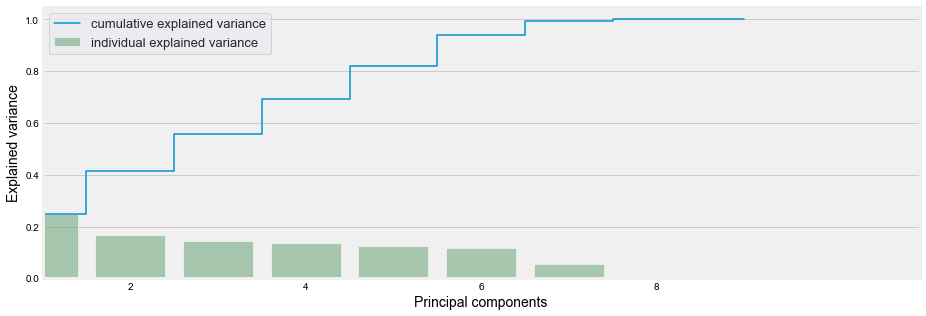

In [22]:
scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(matrix)

pca = PCA()
pca_samples = pca.fit_transform(scaled_matrix)

fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [23]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

selected_customers.loc[:, 'cluster'] = clusters_clients

silhouette score: 0.218


In [28]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

In [36]:
selected_customers

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,12347.0,5,382.52,711.79,558.172000,2790.86,32.408290,8.676179,33.948317,10.442659,14.524555,59,297,10
1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,61.983931,38.016069,0.000000,5,288,2
2,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,0.000000,60.406699,11.692584,27.900718,240,240,2
3,12352.0,6,144.35,840.30,345.663333,2073.98,15.711338,14.301006,66.125517,0.491808,3.370331,2,226,2
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,22.359551,57.752809,0.000000,19.887640,134,134,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,18280.0,1,180.60,180.60,180.600000,180.60,24.833887,34.025471,0.000000,0.000000,41.140642,207,207,3
3608,18281.0,1,80.82,80.82,80.820000,80.82,0.000000,0.000000,62.360802,18.708241,18.930958,110,110,2
3609,18282.0,1,98.76,98.76,98.760000,98.76,13.669502,0.000000,49.058323,19.349939,17.922236,56,56,10
3610,18283.0,10,2.50,192.80,108.683000,1086.83,8.290165,2.245061,37.352668,17.204163,34.907943,25,267,10


In [29]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [30]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

In [31]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)
svc.grid_predict(X_test, Y_test)

Precision: 82.43 % 


In [32]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


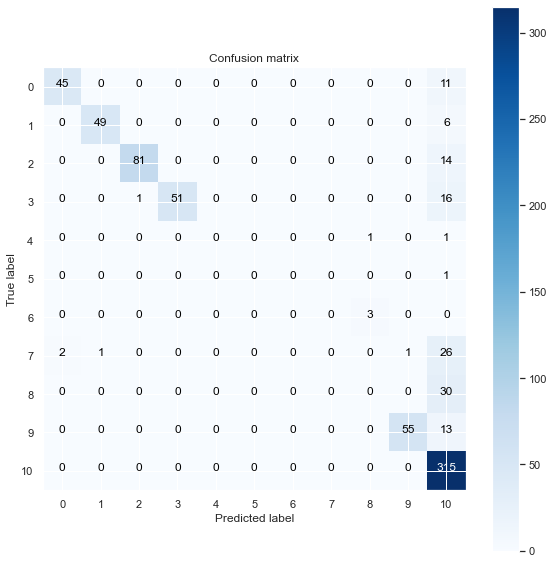

In [33]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

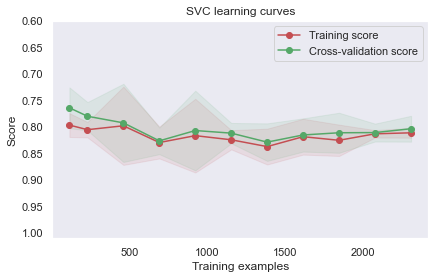

In [35]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])